In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from shapely.geometry import Point, LineString
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import trackintel as ti
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, MultiHeadAttention, LayerNormalization, Add, Concatenate, Masking
from tensorflow import nn
from tensorflow.keras.models import load_model
from IPython.display import display
import gc
import pickle
import matplotlib.pyplot as plt


In [6]:
# Load GNSS and POI data (using hiroshima city B)
gnss_data = pd.read_csv('kumamoto_challengedata_cityD.csv')
poi_data = pd.read_csv('POIdata_cityD_kumamoto.csv')
poi_categories = pd.read_csv('POI_datacategories.csv', header=None)


In [7]:
#data cleaning and preparation
#set crs (assuming flat cartesian as latlng mapping not given)
custom_crs = {'proj': 'cart', 'units': 'm'}
# Filter out rows with missing coordinates
gnss_df = gnss_data[(gnss_data['x'] != 999) & (gnss_data['x'] != -999) & (gnss_data['y'] != 999) & (gnss_data['y'] != -999)]
# Scale x and y coordinates by 500 (as each grid unit is 500m)
gnss_df['x'] = gnss_df['x'] * 500
gnss_df['y'] = gnss_df['y'] * 500
poi_data['x'] = poi_data['x'] * 500
poi_data['y'] = poi_data['y'] * 500
# Create geometry column from x and y coordinates
gnss_df['geometry'] = gnss_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
poi_data['geometry'] = poi_data.apply(lambda row: Point(row['x'], row['y']), axis=1)
# Convert to GeoDataFrame with the flat Cartesian CRS
gnss_gdf = gpd.GeoDataFrame(gnss_df, geometry='geometry', crs=custom_crs)
poi_gdf = gpd.GeoDataFrame(poi_data, geometry='geometry', crs=custom_crs)

# data preprocessing 
# Convert 'd' (day of the year) to a full date, assuming day 0 is January 1st 2024 and timezone is UTC
year = 2024
gnss_gdf['date'] = pd.to_datetime(year * 1000 + gnss_gdf['d'] + 1, format='%Y%j')
# Convert 't' (half-hour period of the day) into a timedelta object
gnss_gdf['time'] = pd.to_timedelta(gnss_gdf['t'] * 30, unit='m')
# Combine 'date' and 'time' into a new 'tracked_at' DateTime column
gnss_gdf['tracked_at'] = gnss_gdf['date'] + gnss_gdf['time']
# Drop columns if they are no longer needed
gnss_gdf = gnss_gdf.drop(columns=['date', 'time', 'd', 't', 'x', 'y'])
poi_gdf = poi_gdf.drop(columns=['x', 'y'])

display(gnss_gdf)
display(poi_gdf)


/var/folders/s7/6lnfr9k13ll1y7pzl866321w0000gn/T/ipykernel_10778/2962390501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnss_df['x'] = gnss_df['x'] * 500
/var/folders/s7/6lnfr9k13ll1y7pzl866321w0000gn/T/ipykernel_10778/2962390501.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnss_df['y'] = gnss_df['y'] * 500
/var/folders/s7/6lnfr9k13ll1y7pzl866321w0000gn/T/ipykernel_10778/2962390501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,uid,geometry,tracked_at
0,0,POINT (66500.00000 51500.00000),2024-01-01 06:30:00
1,0,POINT (71500.00000 49000.00000),2024-01-01 07:00:00
2,0,POINT (81000.00000 49500.00000),2024-01-01 08:00:00
3,0,POINT (74500.00000 48500.00000),2024-01-01 08:30:00
4,0,POINT (72000.00000 49000.00000),2024-01-01 09:00:00
...,...,...,...
7593397,5999,POINT (45500.00000 59000.00000),2024-02-29 21:30:00
7593398,5999,POINT (46000.00000 59000.00000),2024-02-29 22:00:00
7593399,5999,POINT (45500.00000 59000.00000),2024-02-29 22:30:00
7593400,5999,POINT (45500.00000 59000.00000),2024-02-29 23:00:00


,category,POI_count,geometry
0,46,1,POINT (500.00000 5500.00000)
1,60,2,POINT (500.00000 27500.00000)
2,48,1,POINT (500.00000 27500.00000)
3,68,1,POINT (500.00000 28000.00000)
4,75,1,POINT (500.00000 28000.00000)
...,...,...,...
72789,39,1,POINT (100000.00000 96000.00000)
72790,73,1,POINT (100000.00000 96500.00000)
72791,75,1,POINT (100000.00000 96500.00000)
72792,38,1,POINT (100000.00000 96500.00000)


In [8]:
# Obtain positionfixes (raw time and spatial coordinates) dataframe
original_positionfixes = ti.io.read_positionfixes_gpd(
    gnss_gdf,
    tracked_at='tracked_at',   # Column storing timestamps
    user_id='uid',         
    crs=custom_crs,            # Coordinate reference system
    tz="UTC",                  # Timezone
)
# Display the resulting positionfixes GeoDataFrame
display(original_positionfixes)


,user_id,geometry,tracked_at
0,0,POINT (66500.00000 51500.00000),2024-01-01 06:30:00+00:00
1,0,POINT (71500.00000 49000.00000),2024-01-01 07:00:00+00:00
2,0,POINT (81000.00000 49500.00000),2024-01-01 08:00:00+00:00
3,0,POINT (74500.00000 48500.00000),2024-01-01 08:30:00+00:00
4,0,POINT (72000.00000 49000.00000),2024-01-01 09:00:00+00:00
...,...,...,...
7593397,5999,POINT (45500.00000 59000.00000),2024-02-29 21:30:00+00:00
7593398,5999,POINT (46000.00000 59000.00000),2024-02-29 22:00:00+00:00
7593399,5999,POINT (45500.00000 59000.00000),2024-02-29 22:30:00+00:00
7593400,5999,POINT (45500.00000 59000.00000),2024-02-29 23:00:00+00:00


In [9]:
# given more computational time and space, we can train our neural network with more data, and given real-world latlng coordinates we can also train it on data from different cities
# for demo, use only data for first 50% of time period and users as data set is too large
user_limit = 0.5 * original_positionfixes['user_id'].nunique()
# sort the entire DataFrame by `user_id` and `tracked_at`
positionfixes = original_positionfixes.sort_values(by=['user_id', 'tracked_at'])
# Group by `user_id` and apply a function to take the first half of each group
positionfixes = positionfixes.groupby('user_id').apply(lambda x: x.iloc[:len(x) // 2])
# Drop the extra index level added by groupby
positionfixes = positionfixes.reset_index(drop=True)
# Filter the DataFrame to include only rows where `user_id` is < user_limit
positionfixes = positionfixes[positionfixes['user_id'] < user_limit]
# Display the reduced DataFrame
display(positionfixes)


,user_id,geometry,tracked_at
0,0,POINT (66500.00000 51500.00000),2024-01-01 06:30:00+00:00
1,0,POINT (71500.00000 49000.00000),2024-01-01 07:00:00+00:00
2,0,POINT (81000.00000 49500.00000),2024-01-01 08:00:00+00:00
3,0,POINT (74500.00000 48500.00000),2024-01-01 08:30:00+00:00
4,0,POINT (72000.00000 49000.00000),2024-01-01 09:00:00+00:00
...,...,...,...
2175457,2999,POINT (37500.00000 48000.00000),2024-02-02 06:00:00+00:00
2175458,2999,POINT (37500.00000 48000.00000),2024-02-02 06:30:00+00:00
2175459,2999,POINT (37500.00000 47500.00000),2024-02-02 07:00:00+00:00
2175460,2999,POINT (45500.00000 59000.00000),2024-02-02 07:30:00+00:00


In [10]:
# monkey patch to use euclidean distance metric since we only have grid coordinates and not latlng while trackintel only support haversine distance
# Reference: trackintel
from trackintel import Positionfixes, Staypoints, Triplegs
from trackintel.geogr import check_gdf_planar, point_haversine_dist
from trackintel.preprocessing.util import _explode_agg, angle_centroid_multipoints, applyParallel

def point_euclidean_dist(x1, y1, x2, y2, float_flag=True):
    """Calculate Euclidean distance between two points in a flat Cartesian coordinate system."""
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def custom_generate_staypoints_sliding_user(
    df,
    geo_col,
    elevation_flag,
    dist_threshold,
    time_threshold,
    gap_threshold,
    distance_metric,
    include_last=False,
):
    """User level staypoint generation using sliding method, see generate_staypoints() function for parameter meaning."""
    if distance_metric == "haversine":
        dist_func = point_haversine_dist
    elif distance_metric == "euclidean":
        dist_func = point_euclidean_dist  # Use Euclidean distance function
    else:
        raise ValueError("distance_metric unknown. We only support ['haversine', 'euclidean']. " f"You passed {distance_metric}")

    df = df.sort_index(kind="stable").sort_values(by=["tracked_at"], kind="stable")

    # transform times to pandas Timedelta to simplify comparisons
    gap_threshold = pd.Timedelta(gap_threshold, unit="minutes")
    time_threshold = pd.Timedelta(time_threshold, unit="minutes")
    # to numpy as access time of numpy array is faster than pandas Series
    gap_times = ((df.tracked_at - df.tracked_at.shift(1)) > gap_threshold).to_numpy()

    # put x and y into numpy arrays to speed up the access in the for loop (shapely is slow)
    x = df[geo_col].x.to_numpy()
    y = df[geo_col].y.to_numpy()

    ret_sp = []
    curr = start = 0
    for curr in range(1, len(df)):
        # the gap of two consecutive positionfixes should not be too long
        if gap_times[curr]:
            start = curr
            continue

        delta_dist = dist_func(x[start], y[start], x[curr], y[curr], float_flag=True)
        if delta_dist >= dist_threshold:
            # we want the staypoint to have long enough duration
            if (df["tracked_at"].iloc[curr] - df["tracked_at"].iloc[start]) >= time_threshold:
                ret_sp.append(__create_new_staypoints(start, curr, df, elevation_flag, geo_col))
            # distance large enough but time is too short -> not a staypoint
            # also initializer when new sp is added
            start = curr
        
    if include_last:  # aggregate remaining positionfixes
        # additional control: we aggregate only if duration longer than time_threshold
        if (df["tracked_at"].iloc[curr] - df["tracked_at"].iloc[start]) >= time_threshold:
            new_sp = __create_new_staypoints(start, curr, df, elevation_flag, geo_col, last_flag=True)
            ret_sp.append(new_sp)

    ret_sp = pd.DataFrame(ret_sp)
    ret_sp["user_id"] = df["user_id"].unique()[0]
    return ret_sp

def __create_new_staypoints(start, end, pfs, elevation_flag, geo_col, last_flag=False):
    """Create a staypoint with relevant information from start to end pfs."""
    new_sp = {}

    # Here we consider pfs[end] time for stp 'finished_at', but only include
    # pfs[end - 1] for stp geometry and pfs linkage.
    new_sp["started_at"] = pfs["tracked_at"].iloc[start]
    new_sp["finished_at"] = pfs["tracked_at"].iloc[end]

    # if end is the last pfs, we want to include the info from it as well
    if last_flag:
        end = len(pfs)
    points = pfs[geo_col].iloc[start:end]
    if check_gdf_planar(pfs):
        new_sp[geo_col] = points.unary_union.centroid
    else:
        new_sp[geo_col] = angle_centroid_multipoints(points.unary_union)[0]

    if elevation_flag:
        new_sp["elevation"] = pfs["elevation"].iloc[start:end].median()
    new_sp["pfs_id"] = pfs.index[start:end].to_list()

    return new_sp

# Monkey-patch the function in trackintel so that it will use our custom function
ti.preprocessing.positionfixes._generate_staypoints_sliding_user = custom_generate_staypoints_sliding_user


In [11]:
# define minimum time and distance between adjacent positionfixes
temporal_resolution = 30
spatial_resolution = 500
# generate staypoints, which are sets of sufficiently close (distance threshold) positionfixes across sufficiently long time period (time threshold)
positionfixes, staypoints = ti.preprocessing.generate_staypoints(
    positionfixes,
    method='sliding',
    distance_metric='euclidean',  # Use the patched Euclidean distance metric as we assume flat cartesian coordinates
    dist_threshold = spatial_resolution, # ensures each staypoint contain stationary positionfixes only (cover 1 grid (0.25 km2 area))
    time_threshold = temporal_resolution + 1, # ensures each staypoint contains more than 1 positionfix
    gap_threshold = 2*temporal_resolution - 1, # do not consider positionfixes with time gap in tracking
    print_progress=True
)

# Display the resulting staypoints
display(positionfixes)
display(staypoints)


100%|███████████████████████████████████████| 3000/3000 [01:57<00:00, 25.59it/s]


,user_id,geometry,tracked_at,staypoint_id
0,0,POINT (66500.00000 51500.00000),2024-01-01 06:30:00+00:00,<NA>
1,0,POINT (71500.00000 49000.00000),2024-01-01 07:00:00+00:00,<NA>
2,0,POINT (81000.00000 49500.00000),2024-01-01 08:00:00+00:00,<NA>
3,0,POINT (74500.00000 48500.00000),2024-01-01 08:30:00+00:00,<NA>
4,0,POINT (72000.00000 49000.00000),2024-01-01 09:00:00+00:00,<NA>
...,...,...,...,...
2175457,2999,POINT (37500.00000 48000.00000),2024-02-02 06:00:00+00:00,171104
2175458,2999,POINT (37500.00000 48000.00000),2024-02-02 06:30:00+00:00,171104
2175459,2999,POINT (37500.00000 47500.00000),2024-02-02 07:00:00+00:00,<NA>
2175460,2999,POINT (45500.00000 59000.00000),2024-02-02 07:30:00+00:00,<NA>


,user_id,started_at,finished_at,geometry
id,,,,
0,0,2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+00:00,POINT (71500.00000 49000.00000)
1,0,2024-01-04 18:30:00+00:00,2024-01-04 19:30:00+00:00,POINT (71500.00000 49000.00000)
2,0,2024-01-09 06:30:00+00:00,2024-01-09 07:30:00+00:00,POINT (72000.00000 49000.00000)
3,0,2024-01-12 13:00:00+00:00,2024-01-12 14:00:00+00:00,POINT (72000.00000 48500.00000)
4,0,2024-01-17 11:30:00+00:00,2024-01-17 12:30:00+00:00,POINT (60500.00000 50000.00000)
...,...,...,...,...
171100,2999,2024-02-01 00:30:00+00:00,2024-02-01 01:30:00+00:00,POINT (37500.00000 47500.00000)
171101,2999,2024-02-01 02:30:00+00:00,2024-02-01 04:00:00+00:00,POINT (37000.00000 47500.00000)
171102,2999,2024-02-01 04:30:00+00:00,2024-02-01 06:00:00+00:00,POINT (37000.00000 47500.00000)


In [12]:
# min inter-cluster distance = ((epislon // spatial_resolution) + 1)*spatial_resolution
min_intercluster_distance = 1000
# Generate locations which are DBSCAN clusters of staypoints
staypoints, locations = ti.preprocessing.generate_locations(
    staypoints,
    method='dbscan',
    epsilon = min_intercluster_distance - spatial_resolution,  # Epsilon for DBSCAN which determines min distance between locations
    num_samples=1, # minPts = 1 for DBSCAN to ensure every staypoint belongs to a location (no outliers)
    distance_metric='euclidean',
    print_progress=True,        
)

# Display the resulting staypoints and locations DataFrames
display(staypoints)
display(locations)


100%|██████████████████████████████████████| 2981/2981 [00:03<00:00, 850.68it/s]


,user_id,started_at,finished_at,geometry,location_id
id,,,,,
0,0,2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+00:00,POINT (71500.00000 49000.00000),0
1,0,2024-01-04 18:30:00+00:00,2024-01-04 19:30:00+00:00,POINT (71500.00000 49000.00000),0
2,0,2024-01-09 06:30:00+00:00,2024-01-09 07:30:00+00:00,POINT (72000.00000 49000.00000),0
3,0,2024-01-12 13:00:00+00:00,2024-01-12 14:00:00+00:00,POINT (72000.00000 48500.00000),0
4,0,2024-01-17 11:30:00+00:00,2024-01-17 12:30:00+00:00,POINT (60500.00000 50000.00000),1
...,...,...,...,...,...
171100,2999,2024-02-01 00:30:00+00:00,2024-02-01 01:30:00+00:00,POINT (37500.00000 47500.00000),22173
171101,2999,2024-02-01 02:30:00+00:00,2024-02-01 04:00:00+00:00,POINT (37000.00000 47500.00000),22173
171102,2999,2024-02-01 04:30:00+00:00,2024-02-01 06:00:00+00:00,POINT (37000.00000 47500.00000),22173


,user_id,center,extent
id,,,
0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236..."
1,0,POINT (60500.00000 50000.00000),"POLYGON ((61000.00000 50000.00000, 60997.59236..."
2,0,POINT (39000.00000 79500.00000),"POLYGON ((39500.00000 79500.00000, 39497.59236..."
3,0,POINT (40000.00000 96500.00000),"POLYGON ((40500.00000 96500.00000, 40497.59236..."
4,0,POINT (39500.00000 94000.00000),"POLYGON ((40000.00000 94000.00000, 39997.59236..."
...,...,...,...
22174,2999,POINT (38500.00000 45250.00000),"POLYGON ((38000.00000 45500.00000, 38002.40764..."
22175,2999,POINT (50000.00000 51000.00000),"POLYGON ((50500.00000 51000.00000, 50497.59236..."
22176,2999,POINT (45500.00000 47000.00000),"POLYGON ((46000.00000 47000.00000, 45997.59236..."


In [13]:
# Define important constants and model input dimensions
# number of unique POI categories
num_of_POIcategories = len(poi_categories)
# length of historical sequence of consecutive staypoints
sequence_length = 99   
# Dimension of embedding of user_id
user_embedding_dim = 16   
# Dimension of embedding of location_id
location_embedding_dim = 32
# Dimension of embedding for each x & y coordinates of a location (centroid of its staypoints set)
coordinate_embedding_dim = 8   
# Dimension of embedding for start time of staypoint
arrivaltime_embedding_dim = 3  
# Dimension of embedding for start day of staypoint
arrivalday_embedding_dim = 3 
# dimension of embedding for duration of staypoint
duration_embedding_dim = 8
# Dimension of embedding for area of convex hull of a location's staypoints set
convexarea_embedding_dim = 10 
# Dimension of context vector (obtained by LDA from 1-km radius POI vector), i.e. number of topics present among the locations and POI categories
context_dim = 20 
# Number of attention heads
num_heads = 4 
# Total number of unique users in df
num_users = positionfixes['user_id'].nunique()    
# Total number of unique locations in df
num_locations = len(locations)   
# Total embedding dimension for Multi-Head Self Attention neural network (sum of individual dimensions, exclude user embedding)
combined_embedding_dim = location_embedding_dim + context_dim + 2 * coordinate_embedding_dim + arrivaltime_embedding_dim + arrivalday_embedding_dim + duration_embedding_dim + convexarea_embedding_dim


In [11]:
# vicinity around location centre to count POIs for its context information
vicinity_radius = 1000
# Function to compute POI vector for each location, element j of the vector gives the count of POIs of category j within vicinity of the location's centre
def compute_poi_vector(location):
    # Create a buffer (1000m radius) around the location center
    buffer = location['center'].buffer(vicinity_radius)
    
    # Filter POIs that fall within this buffer
    poi_in_buffer = poi_gdf[poi_gdf['geometry'].within(buffer)]
    
    # Initialize a zero vector of dimension `vector_dim`
    poi_vector = np.zeros(num_of_POIcategories)
    
    # Count POIs by category within the buffer
    for _, poi in poi_in_buffer.iterrows():
        category = poi['category']
        count = poi['POI_count']
        poi_vector[category - 1] += count
    
    return poi_vector

# Apply function to each location and create the `POI_vector` column
locations['POI_vector'] = locations.apply(compute_poi_vector, axis=1)
# Display the resulting DataFrame
display(locations)


,user_id,center,extent,POI_vector
id,,,,
0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,..."
1,0,POINT (60500.00000 50000.00000),"POLYGON ((61000.00000 50000.00000, 60997.59236...","[0.0, 0.0, 0.0, 6.0, 2.0, 0.0, 1.0, 0.0, 3.0, ..."
2,0,POINT (39000.00000 79500.00000),"POLYGON ((39500.00000 79500.00000, 39497.59236...","[0.0, 0.0, 1.0, 12.0, 2.0, 0.0, 1.0, 0.0, 1.0,..."
3,0,POINT (40000.00000 96500.00000),"POLYGON ((40500.00000 96500.00000, 40497.59236...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,POINT (39500.00000 94000.00000),"POLYGON ((40000.00000 94000.00000, 39997.59236...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
22174,2999,POINT (38500.00000 45250.00000),"POLYGON ((38000.00000 45500.00000, 38002.40764...","[0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 2.0, 0.0, 0.0, ..."
22175,2999,POINT (50000.00000 51000.00000),"POLYGON ((50500.00000 51000.00000, 50497.59236...","[22.0, 1.0, 7.0, 453.0, 155.0, 10.0, 35.0, 29...."
22176,2999,POINT (45500.00000 47000.00000),"POLYGON ((46000.00000 47000.00000, 45997.59236...","[0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
# Reference: (Hong et al., 2023)
# Treat each location as a document and each POI category as a word
# POI vectors can then be viewed as Bag-Of-Word (BOW) vectors
# Stack them into BOW matrix, where the rows of the matrix are BOW vectors
poi_bow_matrix = np.stack(locations['POI_vector'].values)
# Initialize and fit the Latent Dirichlet Allocation (LDA) model
lda = LatentDirichletAllocation(n_components=context_dim, random_state=0)
lda.fit(poi_bow_matrix)
# Transform BOW matrix to get topic distribution matrix, where row i is the context (topic distribution) vector of location i 
# element j of this vector gives the probability of topic j occuring in location i 
topic_distributions = lda.transform(poi_bow_matrix)
# Append topic distribution vectors to the `locations` DataFrame
locations['POIcontext_vector'] = list(topic_distributions)
# Display the resulting DataFrame with topic distributions
display(locations)


,user_id,center,extent,POI_vector,POIcontext_vector
id,,,,,
0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7..."
1,0,POINT (60500.00000 50000.00000),"POLYGON ((61000.00000 50000.00000, 60997.59236...","[0.0, 0.0, 0.0, 6.0, 2.0, 0.0, 1.0, 0.0, 3.0, ...","[0.04687014545798701, 0.0399132364654198, 0.36..."
2,0,POINT (39000.00000 79500.00000),"POLYGON ((39500.00000 79500.00000, 39497.59236...","[0.0, 0.0, 1.0, 12.0, 2.0, 0.0, 1.0, 0.0, 1.0,...","[0.12723345136741226, 0.00019607843594401524, ..."
3,0,POINT (40000.00000 96500.00000),"POLYGON ((40500.00000 96500.00000, 40497.59236...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.012500000227589111, 0.012500000187013825, 0..."
4,0,POINT (39500.00000 94000.00000),"POLYGON ((40000.00000 94000.00000, 39997.59236...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0035714286536483006, 0.003571428643698315, ..."
...,...,...,...,...,...
22174,2999,POINT (38500.00000 45250.00000),"POLYGON ((38000.00000 45500.00000, 38002.40764...","[0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.07238842618287554, 0.00017482517835097226, ..."
22175,2999,POINT (50000.00000 51000.00000),"POLYGON ((50500.00000 51000.00000, 50497.59236...","[22.0, 1.0, 7.0, 453.0, 155.0, 10.0, 35.0, 29....","[9.756097805016632e-06, 9.756097817059026e-06,..."
22176,2999,POINT (45500.00000 47000.00000),"POLYGON ((46000.00000 47000.00000, 45997.59236...","[0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0004807692409902824, 0.00048076924104766493..."


In [13]:
# A set of points is convex iff it contains every line formed by any pair of its points
# The convex hull of a set is the unique minimal convex set containing it
# this polygon and its vertices are given in locations['extent']
# Calculate the area of this polygon and add it as a new column 'convex_hull_area'
locations['convex_hull_area'] = locations['extent'].apply(lambda poly: poly.area)
display(locations)

,user_id,center,extent,POI_vector,POIcontext_vector,convex_hull_area
id,,,,,,
0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
1,0,POINT (60500.00000 50000.00000),"POLYGON ((61000.00000 50000.00000, 60997.59236...","[0.0, 0.0, 0.0, 6.0, 2.0, 0.0, 1.0, 0.0, 3.0, ...","[0.04687014545798701, 0.0399132364654198, 0.36...",7.841371e+05
2,0,POINT (39000.00000 79500.00000),"POLYGON ((39500.00000 79500.00000, 39497.59236...","[0.0, 0.0, 1.0, 12.0, 2.0, 0.0, 1.0, 0.0, 1.0,...","[0.12723345136741226, 0.00019607843594401524, ...",7.841371e+05
3,0,POINT (40000.00000 96500.00000),"POLYGON ((40500.00000 96500.00000, 40497.59236...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.012500000227589111, 0.012500000187013825, 0...",7.841371e+05
4,0,POINT (39500.00000 94000.00000),"POLYGON ((40000.00000 94000.00000, 39997.59236...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0035714286536483006, 0.003571428643698315, ...",7.841371e+05
...,...,...,...,...,...,...
22174,2999,POINT (38500.00000 45250.00000),"POLYGON ((38000.00000 45500.00000, 38002.40764...","[0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.07238842618287554, 0.00017482517835097226, ...",1.284137e+06
22175,2999,POINT (50000.00000 51000.00000),"POLYGON ((50500.00000 51000.00000, 50497.59236...","[22.0, 1.0, 7.0, 453.0, 155.0, 10.0, 35.0, 29....","[9.756097805016632e-06, 9.756097817059026e-06,...",7.841371e+05
22176,2999,POINT (45500.00000 47000.00000),"POLYGON ((46000.00000 47000.00000, 45997.59236...","[0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0004807692409902824, 0.00048076924104766493...",7.841371e+05


In [14]:
# Filter out rows with <NA> in `staypoint_id` from positionfixes
filtered_positionfixes = positionfixes.dropna(subset=['staypoint_id'])
# Left join filtered_positionfixes with staypoints on staypoint_id and index column of staypoints
positionfixes_with_staypoints = filtered_positionfixes.merge(staypoints, left_on='staypoint_id', right_index=True, how='left', suffixes=('_pf', '_stp'))
# Left join the result with locations on location_id and index column of locations
positionfixes_with_all_info = positionfixes_with_staypoints.merge(locations, left_on='location_id', right_index=True, how='left', suffixes=('_1', '_2'))
# Display the resulting DataFrame
display(positionfixes_with_all_info)


,user_id_pf,geometry_pf,tracked_at,staypoint_id,user_id_stp,started_at,finished_at,geometry_stp,location_id,user_id,center,extent,POI_vector,POIcontext_vector,convex_hull_area
64,0,POINT (71500.00000 49000.00000),2024-01-04 08:00:00+00:00,0,0,2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+00:00,POINT (71500.00000 49000.00000),0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
65,0,POINT (71500.00000 49000.00000),2024-01-04 08:30:00+00:00,0,0,2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+00:00,POINT (71500.00000 49000.00000),0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
81,0,POINT (71500.00000 49000.00000),2024-01-04 18:30:00+00:00,1,0,2024-01-04 18:30:00+00:00,2024-01-04 19:30:00+00:00,POINT (71500.00000 49000.00000),0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
82,0,POINT (71500.00000 49000.00000),2024-01-04 19:00:00+00:00,1,0,2024-01-04 18:30:00+00:00,2024-01-04 19:30:00+00:00,POINT (71500.00000 49000.00000),0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
171,0,POINT (72000.00000 49000.00000),2024-01-09 06:30:00+00:00,2,0,2024-01-09 06:30:00+00:00,2024-01-09 07:30:00+00:00,POINT (72000.00000 49000.00000),0,0,POINT (71833.33333 48833.33333),"POLYGON ((72500.00000 48500.00000, 72497.59236...","[4.0, 0.0, 4.0, 31.0, 6.0, 0.0, 4.0, 2.0, 4.0,...","[0.06896656773147936, 7.022472084883288e-05, 7...",1.762691e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175454,2999,POINT (37500.00000 48000.00000),2024-02-02 04:30:00+00:00,171104,2999,2024-02-02 04:00:00+00:00,2024-02-02 07:00:00+00:00,POINT (37500.00000 48000.00000),22173,2999,POINT (37500.00000 48000.00000),"POLYGON ((37000.00000 47000.00000, 36951.63659...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00033557047823485107, 0.0003355704777030628...",2.902170e+06
2175455,2999,POINT (37500.00000 48000.00000),2024-02-02 05:00:00+00:00,171104,2999,2024-02-02 04:00:00+00:00,2024-02-02 07:00:00+00:00,POINT (37500.00000 48000.00000),22173,2999,POINT (37500.00000 48000.00000),"POLYGON ((37000.00000 47000.00000, 36951.63659...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00033557047823485107, 0.0003355704777030628...",2.902170e+06
2175456,2999,POINT (37500.00000 48000.00000),2024-02-02 05:30:00+00:00,171104,2999,2024-02-02 04:00:00+00:00,2024-02-02 07:00:00+00:00,POINT (37500.00000 48000.00000),22173,2999,POINT (37500.00000 48000.00000),"POLYGON ((37000.00000 47000.00000, 36951.63659...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00033557047823485107, 0.0003355704777030628...",2.902170e+06
2175457,2999,POINT (37500.00000 48000.00000),2024-02-02 06:00:00+00:00,171104,2999,2024-02-02 04:00:00+00:00,2024-02-02 07:00:00+00:00,POINT (37500.00000 48000.00000),22173,2999,POINT (37500.00000 48000.00000),"POLYGON ((37000.00000 47000.00000, 36951.63659...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00033557047823485107, 0.0003355704777030628...",2.902170e+06


In [15]:
# Sort and group positionfixes_with_all_info by user_id
user_grouped_data = (
    positionfixes_with_all_info
    .sort_values(by=['user_id', 'tracked_at'])
    .groupby('user_id')
    .agg(
        all_staypoints_id=('staypoint_id', list),
        all_locations_id=('location_id', list),
        all_arrival_dayofweek=('started_at', lambda x: list(dt.dayofweek for dt in x)),
        all_arrival_times=('started_at', lambda x: list(dt.hour + dt.minute / 60 for dt in x)),
        all_durations=('staypoint_id', lambda x: list((positionfixes_with_all_info.loc[x.index, 'finished_at'] - positionfixes_with_all_info.loc[x.index, 'started_at']).dt.total_seconds() / 3600)),
        all_context=('POIcontext_vector', list),
        all_x_coordinates=('center', lambda x: list(pt.x for pt in x)),
        all_y_coordinates=('center', lambda x: list(pt.y for pt in x)),
        all_convex_hull_area=('convex_hull_area', list)
    )
).reset_index()

# Filter users to keep only those with at least 100 staypoints (as we want our input sequence length to be 99)
user_grouped_data = user_grouped_data[user_grouped_data['all_staypoints_id'].apply(len) >= 100]
# Display the resulting DataFrame
display(user_grouped_data)


,user_id,all_staypoints_id,all_locations_id,all_arrival_dayofweek,all_arrival_times,all_durations,all_context,all_x_coordinates,all_y_coordinates,all_convex_hull_area
3,3,"[94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 9...","[28, 28, 29, 29, 28, 28, 29, 29, 28, 28, 29, 2...","[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, ...","[6.0, 6.0, 7.0, 7.0, 16.0, 16.0, 10.5, 10.5, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.001160336390654486, 0.029624423149079916, ...","[95000.0, 95000.0, 95500.0, 95500.0, 95000.0, ...","[1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0,...","[784137.1226364853, 784137.1226364853, 784137...."
6,6,"[184, 184, 185, 185, 185, 185, 186, 186, 187, ...","[45, 45, 46, 46, 46, 46, 45, 45, 45, 45, 46, 4...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[12.5, 12.5, 9.5, 9.5, 9.5, 9.5, 11.5, 11.5, 1...","[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...","[[0.02645627330897756, 0.04780919815744845, 0....","[60300.0, 60300.0, 57666.666666666664, 57666.6...","[49100.0, 49100.0, 50833.333333333336, 50833.3...","[2512690.51322976, 2512690.51322976, 1762690.5..."
7,7,"[262, 262, 263, 263, 264, 264, 265, 265, 266, ...","[50, 50, 51, 51, 51, 51, 52, 52, 53, 53, 53, 5...","[0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...","[10.5, 10.5, 8.5, 8.5, 9.5, 9.5, 10.5, 10.5, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.13417462604119046, 8.865248434259608e-05, ...","[63000.0, 63000.0, 63500.0, 63500.0, 63500.0, ...","[35000.0, 35000.0, 35750.0, 35750.0, 35750.0, ...","[784137.1226364849, 784137.1226364849, 1284137..."
8,8,"[307, 307, 308, 308, 309, 309, 310, 310, 311, ...","[59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 6...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, ...","[7.0, 7.0, 4.5, 4.5, 22.5, 22.5, 23.5, 23.5, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.0008064516286881521, 0.10943009965308219, ...","[55800.0, 55800.0, 55800.0, 55800.0, 55800.0, ...","[65700.0, 65700.0, 65700.0, 65700.0, 65700.0, ...","[2821706.447370262, 2821706.447370262, 2821706..."
11,11,"[391, 391, 392, 392, 392, 392, 392, 392, 392, ...","[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, ...","[[0.00023809524345113622, 0.000238095243247757...","[79250.0, 79250.0, 79250.0, 79250.0, 79250.0, ...","[26000.0, 26000.0, 26000.0, 26000.0, 26000.0, ...","[1284137.122636485, 1284137.122636485, 1284137..."
...,...,...,...,...,...,...,...,...,...,...
2970,2989,"[170466, 170466, 170467, 170467, 170468, 17046...","[22100, 22100, 22100, 22100, 22100, 22100, 221...","[0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[1.0, 1.0, 6.0, 6.0, 9.0, 9.0, 10.5, 10.5, 12....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, ...","[[0.0008196721513274251, 0.0008196721463897286...","[58000.0, 58000.0, 58000.0, 58000.0, 58000.0, ...","[37500.0, 37500.0, 37500.0, 37500.0, 37500.0, ...","[1784137.1226364851, 1784137.1226364851, 17841..."
2973,2992,"[170562, 170562, 170562, 170562, 170563, 17056...","[22122, 22122, 22122, 22122, 22122, 22122, 221...","[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 5, 5, 6, ...","[6.0, 6.0, 6.0, 6.0, 8.5, 8.5, 6.0, 6.0, 12.5,...","[2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.00015673981589224537, 0.000156739816244277...","[90750.0, 90750.0, 90750.0, 90750.0, 90750.0, ...","[31500.0, 31500.0, 31500.0, 31500.0, 31500.0, ...","[1284137.122636485, 1284137.122636485, 1284137..."
2975,2994,"[170655, 170655, 170655, 170656, 170656, 17065...","[22138, 22138, 22138, 22139, 22139, 22139, 221...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, ...","[1.5, 1.5, 1.5, 3.0, 3.0, 3.0, 3.0, 6.0, 6.0, ...","[1.5, 1.5, 1.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[0.12459096599427912, 0.0014705882862873151, ...","[41416.666666666664, 41416.666666666664, 41416...","[57666.666666666664, 57666.666666666664, 57666...","[3093153.056776988, 3093153.056776988, 30931

In [16]:
# Each sequence will consist of same number of consecutive staypoints
# Initialize a list to store each user's 99-length sequences and the next element for each required column
sequence_data = []

# Iterate over each row in user_grouped_data
for _, row in user_grouped_data.iterrows():
    user_id = row['user_id']
    
    # Extract all required sequences as lists
    all_staypoints = row['all_staypoints_id']
    all_locations = row['all_locations_id']
    all_arrival_dayofweek = row['all_arrival_dayofweek']
    all_arrival_times = row['all_arrival_times']
    all_durations = row['all_durations']
    all_context = row['all_context']
    all_x_coordinates = row['all_x_coordinates']
    all_y_coordinates = row['all_y_coordinates']
    all_convex_hull_area = row['all_convex_hull_area']
    
    # Generate overlapping 100-length sequences
    for i in range(0, len(all_staypoints) - 100 + 1): 
        # Get a 100-length slice for each list
        staypoints_sequence = all_staypoints[i:i+100]
        location_sequence = all_locations[i:i+100]
        dayofweek_sequence = all_arrival_dayofweek[i:i+100]
        arrival_time_sequence = all_arrival_times[i:i+100]
        duration_sequence = all_durations[i:i+100]
        context_sequence = all_context[i:i+100]
        x_coordinates_sequence = all_x_coordinates[i:i+100]
        y_coordinates_sequence = all_y_coordinates[i:i+100]
        convex_hull_area_sequence = all_convex_hull_area[i:i+100]
        
        # Split each sequence into the first 99 elements and the next element
        sequence_data.append({
            'user_id': user_id,
            'staypoints_id_sequence': staypoints_sequence[:99],
            'next_staypoint_id': staypoints_sequence[99],
            'location_id_sequence': location_sequence[:99],
            'next_location_id': location_sequence[99],
            'arrival_dayofweek_sequence': dayofweek_sequence[:99],
            'next_arrival_dayofweek': dayofweek_sequence[99],
            'arrival_time_sequence': arrival_time_sequence[:99],
            'next_arrival_time': arrival_time_sequence[99],
            'duration_sequence': duration_sequence[:99],
            'next_duration': duration_sequence[99],
            'context_sequence': context_sequence[:99],
            'next_context': context_sequence[99],
            'x_coordinates': x_coordinates_sequence[:99],
            'next_x_coordinate': x_coordinates_sequence[99],
            'y_coordinates': y_coordinates_sequence[:99],
            'next_y_coordinate': y_coordinates_sequence[99],
            'convex_hull_area': convex_hull_area_sequence[:99],
            'next_convex_hull_area': convex_hull_area_sequence[99]
        })

# Create the new DataFrame with all sequences
clean_sequences_df = pd.DataFrame(sequence_data)

# Display the resulting DataFrame
display(clean_sequences_df)


,user_id,staypoints_id_sequence,next_staypoint_id,location_id_sequence,next_location_id,arrival_dayofweek_sequence,next_arrival_dayofweek,arrival_time_sequence,next_arrival_time,duration_sequence,next_duration,context_sequence,next_context,x_coordinates,next_x_coordinate,y_coordinates,next_y_coordinate,convex_hull_area,next_convex_hull_area
0,3,"[94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 9...",138,"[28, 28, 29, 29, 28, 28, 29, 29, 28, 28, 29, 2...",29,"[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, ...",6,"[6.0, 6.0, 7.0, 7.0, 16.0, 16.0, 10.5, 10.5, 1...",4.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,"[[0.001160336390654486, 0.029624423149079916, ...","[0.0984505345547508, 0.00020080321817110265, 0...","[95000.0, 95000.0, 95500.0, 95500.0, 95000.0, ...",95500.0,"[1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0,...",500.0,"[784137.1226364853, 784137.1226364853, 784137....",7.841371e+05
1,3,"[94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 1...",139,"[28, 29, 29, 28, 28, 29, 29, 28, 28, 29, 29, 2...",28,"[0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, 6, ...",6,"[6.0, 7.0, 7.0, 16.0, 16.0, 10.5, 10.5, 11.5, ...",5.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,"[[0.001160336390654486, 0.029624423149079916, ...","[0.001160336390654486, 0.029624423149079916, 0...","[95000.0, 95500.0, 95500.0, 95000.0, 95000.0, ...",95000.0,"[1000.0, 500.0, 500.0, 1000.0, 1000.0, 500.0, ...",1000.0,"[784137.1226364853, 784137.122636485, 784137.1...",7.841371e+05
2,3,"[95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 100, ...",139,"[29, 29, 28, 28, 29, 29, 28, 28, 29, 29, 28, 2...",28,"[0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, 6, 6, ...",6,"[7.0, 7.0, 16.0, 16.0, 10.5, 10.5, 11.5, 11.5,...",5.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,"[[0.0984505345547508, 0.00020080321817110265, ...","[0.001160336390654486, 0.029624423149079916, 0...","[95500.0, 95500.0, 95000.0, 95000.0, 95500.0, ...",95000.0,"[500.0, 500.0, 1000.0, 1000.0, 500.0, 500.0, 1...",1000.0,"[784137.122636485, 784137.122636485, 784137.12...",7.841371e+05
3,3,"[95, 96, 96, 97, 97, 98, 98, 99, 99, 100, 100,...",140,"[29, 28, 28, 29, 29, 28, 28, 29, 29, 28, 28, 2...",32,"[0, 0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, 6, 6, 6, ...",6,"[7.0, 16.0, 16.0, 10.5, 10.5, 11.5, 11.5, 7.5,...",10.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,"[[0.0984505345547508, 0.00020080321817110265, ...","[0.11145799998988723, 0.0602860809227851, 0.39...","[95500.0, 95000.0, 95000.0, 95500.0, 95500.0, ...",97000.0,"[500.0, 1000.0, 1000.0, 500.0, 500.0, 1000.0, ...",8000.0,"[784137.122636485, 784137.1226364853, 784137.1...",1.784137e+06
4,3,"[96, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101...",140,"[28, 28, 29, 29, 28, 28, 29, 29, 28, 28, 29, 2...",32,"[0, 0, 2, 2, 2, 2, 4, 4, 6, 6, 6, 6, 6, 6, 6, ...",6,"[16.0, 16.0, 10.5, 10.5, 11.5, 11.5, 7.5, 7.5,...",10.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,"[[0.001160336390654486, 0.029624423149079916, ...","[0.11145799998988723, 0.0602860809227851, 0.39...","[95000.0, 95000.0, 95500.0, 95500.0, 95000.0, ...",97000.0,"[1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0,...",8000.0,"[784137.1226364853, 784137.1226364853, 784137....",1.784137e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202079,2999,"[171065, 171066, 171066, 171066, 171067, 17106...",171104,"[22173, 22173, 22173, 22173, 22173, 22173, 221...",22173,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",4,"[0.5, 3.0, 3.0, 3.0, 6.5, 6.5, 22.0, 22.0, 23....",4.0,"[1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,"[[0.00033557047823485107, 0.000335570477703062...","[0.00033557047823485107, 0.0003355704777030628...","[37500.0, 37500.0, 37500.0, 37500.0, 37500.0, ...",37500.0,"[48000.0, 48000.0, 48000.0, 48000.0, 48000.0, ...",48000.0,"[2902169.8482384006, 2902169.8482384006, 29021...",2.902170e+06
202080,2999,"[171066, 171066, 171066, 171067, 171067, 17106...",171104,"[22173, 22173, 22173, 22173, 22173, 22173, 221...",22173,"[1, 1, 1, 1, 1, 1

In [14]:
# Generate sinusoidal positional encoding
# Reference: Vaswani et al., 2017
def get_sinusoidal_positional_encoding(sequence_length, embedding_dim):
    positional_encoding = np.zeros((sequence_length, embedding_dim))
    for pos in range(sequence_length):
        for i in range(embedding_dim):
            angle = pos / np.power(10000, (2 * (i // 2)) / embedding_dim)
            positional_encoding[pos, i] = np.sin(angle) if i % 2 == 0 else np.cos(angle)
    return tf.constant(positional_encoding, dtype=tf.float32)

In [15]:
# Neural Network architecture definition
# Create positional encoding matrix
positional_encoding_matrix = get_sinusoidal_positional_encoding(sequence_length, combined_embedding_dim)

# Input layers
user_id_input = tf.keras.Input(shape=(), dtype=tf.int32, name="user_id")
location_id_sequence_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32, name="location_id_sequence")
arrival_dayofweek_sequence_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32, name="arrival_dayofweek_sequence")
arrival_time_sequence_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.float32, name="arrival_time_sequence")
duration_sequence_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.float32, name="duration_sequence")
context_sequence_input = tf.keras.Input(shape=(sequence_length, context_dim), dtype=tf.float32, name="context_sequence")
x_coordinate_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.float32, name="x_coordinates")
y_coordinate_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.float32, name="y_coordinates")
convex_hull_area_input = tf.keras.Input(shape=(sequence_length,), dtype=tf.float32, name="convex_hull_area")

# Mask invalid values in sequence inputs
location_id_sequence = Masking(mask_value=-1)(location_id_sequence_input)
arrival_dayofweek_sequence = Masking(mask_value=-1)(arrival_dayofweek_sequence_input)
arrival_time_sequence = Masking(mask_value=float('nan'))(arrival_time_sequence_input)
duration_sequence = Masking(mask_value=float('nan'))(duration_sequence_input)
context_sequence = Masking(mask_value=float('nan'))(context_sequence_input)
x_coordinate_sequence = Masking(mask_value=float('nan'))(x_coordinate_input)
y_coordinate_sequence = Masking(mask_value=float('nan'))(y_coordinate_input)
convex_hull_area_sequence = Masking(mask_value=float('nan'))(convex_hull_area_input)

# Embedding layers for user_id and location_id as they are categorical
user_embedding = Embedding(input_dim=num_users, output_dim=user_embedding_dim)(user_id_input)
location_embedding = Embedding(input_dim=num_locations, output_dim=location_embedding_dim)(location_id_sequence)

# Cyclic and linear representation for arrival time as it is periodic every day
arrival_time_normalized = arrival_time_sequence / 24.0  # Normalize to [0, 1]
arrival_time_sin = tf.math.sin(2 * np.pi * arrival_time_normalized)
arrival_time_cos = tf.math.cos(2 * np.pi * arrival_time_normalized)
arrival_time_linear = tf.expand_dims(arrival_time_normalized, -1)  # Linear component
# Concatenate cyclic and linear parts
arrival_time_embedding = Concatenate(axis=-1)([
    tf.expand_dims(arrival_time_sin, -1),
    tf.expand_dims(arrival_time_cos, -1),
    arrival_time_linear
])  # Shape: (batch_size, sequence_length, 3)

# Cyclic and linear representation for arrival_dayofweek as it is periodic every week
arrival_dayofweek_float = tf.cast(arrival_dayofweek_sequence, tf.float32)  # Convert to float for calculations
arrival_dayofweek_normalized = arrival_dayofweek_float / 7.0  # Normalize to [0, 1] range
arrival_dayofweek_sin = tf.math.sin(2 * np.pi * arrival_dayofweek_normalized)
arrival_dayofweek_cos = tf.math.cos(2 * np.pi * arrival_dayofweek_normalized)
arrival_dayofweek_linear = tf.expand_dims(arrival_dayofweek_normalized, -1)  # Linear component normalized
# Concatenate cyclic and linear parts for arrival_dayofweek
arrival_dayofweek_embedding = Concatenate(axis=-1)([
    tf.expand_dims(arrival_dayofweek_sin, -1),
    tf.expand_dims(arrival_dayofweek_cos, -1),
    arrival_dayofweek_linear
])  # Shape: (batch_size, sequence_length, 3)

# Use Dense layer for numeric features
# Dense layer for duration
duration_embedding = Dense(duration_embedding_dim, activation="relu")(tf.expand_dims(duration_sequence, -1))
# Dense layers for coordinates
x_coordinate_embedding = Dense(coordinate_embedding_dim, activation="relu")(tf.expand_dims(x_coordinate_sequence, -1))
y_coordinate_embedding = Dense(coordinate_embedding_dim, activation="relu")(tf.expand_dims(y_coordinate_sequence, -1))
# Dense layer for convex hull area
convex_hull_area_embedding = Dense(convexarea_embedding_dim, activation="relu")(tf.expand_dims(convex_hull_area_sequence, -1))

# Combine all embeddings for each staypoint in the sequence
combined_embeddings = Concatenate(axis=-1)([
    location_embedding,
    context_sequence,
    arrival_dayofweek_embedding,
    arrival_time_embedding,
    duration_embedding,
    x_coordinate_embedding,
    y_coordinate_embedding,
    convex_hull_area_embedding
])  # Shape: (batch_size, sequence_length, combined_embedding_dim)

# Add positional encoding
positional_encoding = tf.expand_dims(positional_encoding_matrix, axis=0)
combined_embeddings_with_position = combined_embeddings + positional_encoding

# Multi-Head Self-Attention
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=int(combined_embedding_dim/num_heads))(combined_embeddings_with_position, combined_embeddings_with_position)

# Add & Normalize
attention_output = Add()([attention_output, combined_embeddings_with_position])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

# Pooling (by mean) 
pooled_output = tf.reduce_mean(attention_output, axis=1)
# concatenate with the user_embedding 
combined_output = tf.concat([pooled_output, user_embedding], axis=-1)

# Dense layers for final prediction, using softmax for probability matrix output
x = Dense(128, activation="relu")(combined_output)
x = Dense(64, activation="relu")(x)
output = Dense(num_locations, activation="softmax")(x)

# Define the updated model
model = tf.keras.Model(
    inputs=[
        user_id_input, 
        location_id_sequence_input,
        arrival_dayofweek_sequence_input,
        arrival_time_sequence_input,
        duration_sequence_input, 
        context_sequence_input, 
        x_coordinate_input, 
        y_coordinate_input, 
        convex_hull_area_input
    ], 
    outputs=output
)
# use sparse_categorical_crossentropy for loss function as y_true is true class labels and not one-hot encoded
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [19]:
# Split data into train:validation:test 60:20:20
train_val_data, test_data = train_test_split(clean_sequences_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

# Convert relevant columns to numpy arrays and compile inputs for the model
xtrain = {
    "user_id": np.array(train_data['user_id']),
    "location_id_sequence": np.array(train_data['location_id_sequence'].tolist()),
    "arrival_dayofweek_sequence": np.array(train_data['arrival_dayofweek_sequence'].tolist()),
    "arrival_time_sequence": np.array(train_data['arrival_time_sequence'].tolist()),
    "duration_sequence": np.array(train_data['duration_sequence'].tolist()),
    "context_sequence": np.array(train_data['context_sequence'].tolist()),
    "x_coordinates": np.array(train_data['x_coordinates'].tolist()),
    "y_coordinates": np.array(train_data['y_coordinates'].tolist()),
    "convex_hull_area": np.array(train_data['convex_hull_area'].tolist())
}

# Extract `next_location` as y_true for training
ytrain = np.array(train_data['next_location_id'])

# Compile validation data in the same format
xval = {
    "user_id": np.array(val_data['user_id']),
    "location_id_sequence": np.array(val_data['location_id_sequence'].tolist()),
    "arrival_dayofweek_sequence": np.array(val_data['arrival_dayofweek_sequence'].tolist()),
    "arrival_time_sequence": np.array(val_data['arrival_time_sequence'].tolist()),
    "duration_sequence": np.array(val_data['duration_sequence'].tolist()),
    "context_sequence": np.array(val_data['context_sequence'].tolist()),
    "x_coordinates": np.array(val_data['x_coordinates'].tolist()),
    "y_coordinates": np.array(val_data['y_coordinates'].tolist()),
    "convex_hull_area": np.array(val_data['convex_hull_area'].tolist())
}
yval = np.array(val_data['next_location_id'])

# Compile test data in the same format
xtest = {
    "user_id": np.array(test_data['user_id']),
    "location_id_sequence": np.array(test_data['location_id_sequence'].tolist()),
    "arrival_dayofweek_sequence": np.array(test_data['arrival_dayofweek_sequence'].tolist()),
    "arrival_time_sequence": np.array(test_data['arrival_time_sequence'].tolist()),
    "duration_sequence": np.array(test_data['duration_sequence'].tolist()),
    "context_sequence": np.array(test_data['context_sequence'].tolist()),
    "x_coordinates": np.array(test_data['x_coordinates'].tolist()),
    "y_coordinates": np.array(test_data['y_coordinates'].tolist()),
    "convex_hull_area": np.array(test_data['convex_hull_area'].tolist())
}
ytest = np.array(test_data['next_location_id'])


In [20]:
# Define a dictionary to store the data
data_to_save = {
    "xtrain": xtrain,
    "ytrain": ytrain,
    "xval": xval,
    "yval": yval,
    "xtest": xtest,
    "ytest": ytest
}

# Save the dictionary to a file
with open("task3_model_data1.pkl", "wb") as f:
    pickle.dump(data_to_save, f)


In [17]:
# Load the data
with open("task3_model_data1.pkl", "rb") as f:
    loaded_data = pickle.load(f)
# Unpack the data
xtrain = loaded_data["xtrain"]
ytrain = loaded_data["ytrain"]
xval = loaded_data["xval"]
yval = loaded_data["yval"]
xtest = loaded_data["xtest"]
ytest = loaded_data["ytest"]

# Train the model with the prepared data
history = model.fit(
    x=xtrain,
    y=ytrain,
    validation_data=(xval, yval),  # Use explicit validation data
    batch_size=32,
    epochs=10
)
# save model state
model.save("task3_model1.h5")


Epoch 1/10
3790/3790 [==============================] - 126s 33ms/step - loss: 5.7240 - accuracy: 0.1803 - val_loss: 3.7527 - val_accuracy: 0.4662
Epoch 2/10
3790/3790 [==============================] - 125s 33ms/step - loss: 2.6577 - accuracy: 0.6069 - val_loss: 2.3228 - val_accuracy: 0.6779
Epoch 3/10
3790/3790 [==============================] - 130s 34ms/step - loss: 1.7065 - accuracy: 0.6979 - val_loss: 1.8476 - val_accuracy: 0.7139
Epoch 4/10
3790/3790 [==============================] - 135s 36ms/step - loss: 1.2870 - accuracy: 0.7215 - val_loss: 1.5540 - val_accuracy: 0.7225
Epoch 5/10
3790/3790 [==============================] - 134s 35ms/step - loss: 1.0674 - accuracy: 0.7296 - val_loss: 1.3884 - val_accuracy: 0.7314
Epoch 6/10
3790/3790 [==============================] - 134s 35ms/step - loss: 0.9466 - accuracy: 0.7352 - val_loss: 1.2825 - val_accuracy: 0.7334
Epoch 7/10
3790/3790 [==============================] - 136s 36ms/step - loss: 0.8805 - accuracy: 0.7373 - val_loss: 1

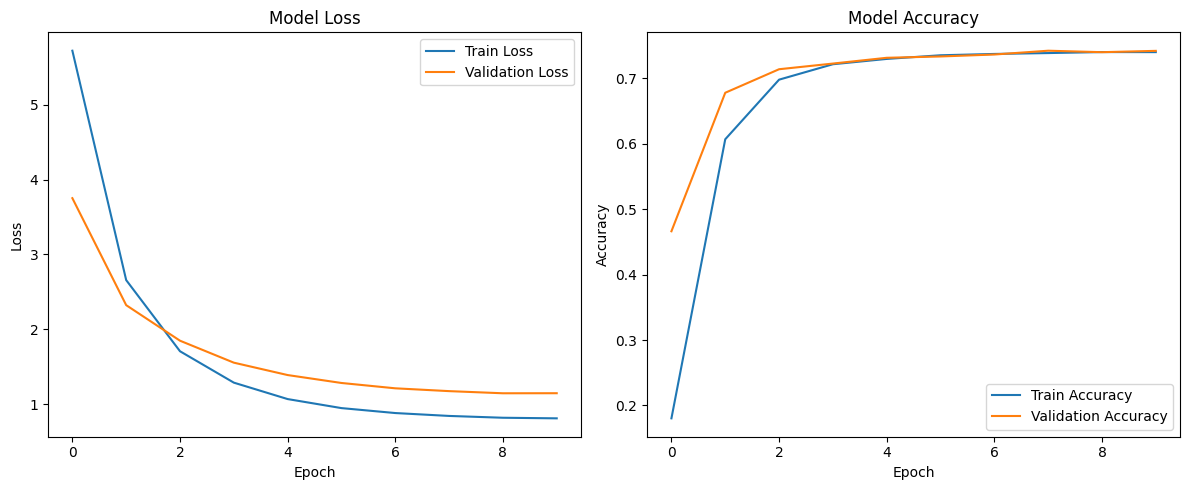

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history.get('accuracy')  # may be 'acc' or 'accuracy'
val_accuracy = history.history.get('val_accuracy')  # may be 'val_acc' or 'val_accuracy'

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [3]:
# Evaluation functions referenced from (Hong et al., 2023)
# compute Mean Reciprocal Rank (MRR) (higher value means better, max score = 1)
def mean_reciprocal_rank(y_true, y_pred):
    # Get the true class index from y_true (for sparse format)
    y_true = tf.cast(y_true, tf.int32)
    
    # Sort predictions to get indices of sorted classes in descending order, 
    #in each row, 1st column gives the class labels with highest probability, 2nd column gives class labels with 2nd highest prob and so on
    sorted_pred = tf.argsort(y_pred, direction='DESCENDING')
    
    # Find the rank of the true label in the sorted predictions
    ranks = tf.argmax(tf.cast(tf.equal(sorted_pred, tf.expand_dims(y_true, axis=-1)), tf.int32), axis=-1) + 1
    
    # Calculate reciprocal of rank and average
    reciprocal_ranks = 1.0 / tf.cast(ranks, tf.float32)
    return tf.reduce_mean(reciprocal_ranks)

# compute top-k accuracy using tf.nn.in_top_k
def compute_top_k_accuracy(y_true, y_pred, k=5):
    # Get bool vector of whether true class label was found in top k predictions 
    #i.e. whether predicted probability of true class label is among k highest probabilities
    top_k_matches = nn.in_top_k(predictions=y_pred, targets=y_true, k=k)
    
    # Calculate the mean accuracy over all samples
    return tf.reduce_mean(tf.cast(top_k_matches, tf.float32))

In [4]:
# clear memory
gc.collect()

46

In [5]:
# Load the model
model = load_model("task3_model1.h5")
# Load the data
with open("task3_model_data1.pkl", "rb") as f:
    loaded_data = pickle.load(f)
# Unpack the data
xtrain = loaded_data["xtrain"]
ytrain = loaded_data["ytrain"]
xval = loaded_data["xval"]
yval = loaded_data["yval"]
xtest = loaded_data["xtest"]
ytest = loaded_data["ytest"]

# Define datasets and labels for easy looping
datasets = [("Train", xtrain, ytrain), ("Validation", xval, yval), ("Test", xtest, ytest)]
top_k_values = [1, 5, 10]

# Loop through each dataset
for name, xdata, ydata in datasets:
    # Get predicted probability matrix
    ypred = model.predict(xdata, batch_size=32)
    # Calculate and print Mean Reciprocal Rank (MRR)
    mrr = mean_reciprocal_rank(ydata, ypred)
    print(f"Mean Reciprocal Rank ({name}):", mrr.numpy())

    # Calculate and print Top-k accuracy for each k value
    for k in top_k_values:
        top_k_acc = compute_top_k_accuracy(ydata, ypred, k=k)
        print(f"Top-{k} Accuracy ({name}):", top_k_acc.numpy())

    # Clear prediction variable to free memory before next loop
    del ypred


3790/3790 [==============================] - 52s 14ms/step
Mean Reciprocal Rank (Train): 0.84960824
Top-1 Accuracy (Train): 0.74713403
Top-5 Accuracy (Train): 0.97859794
Top-10 Accuracy (Train): 0.9953897
1264/1264 [==============================] - 21s 16ms/step
Mean Reciprocal Rank (Validation): 0.8379919
Top-1 Accuracy (Validation): 0.74070317
Top-5 Accuracy (Validation): 0.9574931
Top-10 Accuracy (Validation): 0.9742188
1264/1264 [==============================] - 22s 17ms/step
Mean Reciprocal Rank (Test): 0.83652085
Top-1 Accuracy (Test): 0.73944134
Top-5 Accuracy (Test): 0.95581067
Top-10 Accuracy (Test): 0.9737734
